# SARIMAX 

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 7.5]

## United States Macroeconomic Data

In [3]:
macro_data = sm.datasets.macrodata.load_pandas()

In [4]:
macro_data.data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [5]:
macro_data.data['year'] = macro_data.data['year'].astype(int).astype(str)
macro_data.data['quarter'] = macro_data.data['quarter'].astype(int).astype(str)

In [6]:
macro_data.data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008,3,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008,4,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009,1,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009,2,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [7]:
macro_data.data['time'] = macro_data.data[['year', 'quarter']].agg('-'.join, axis=1)

In [8]:
macro_data.data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,time
0,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00,1959-1
1,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74,1959-2
2,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09,1959-3
3,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06,1959-4
4,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19,1960-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008,3,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33,2008-3
199,2008,4,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91,2008-4
200,2009,1,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71,2009-1
201,2009,2,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19,2009-2


In [9]:
macro_data.data.set_index(['time'])

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
time,,,,,,,,,,,,,,
1959-1,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959-2,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959-3,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959-4,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960-1,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-3,2008,3,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008-4,2008,4,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009-1,2009,1,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71


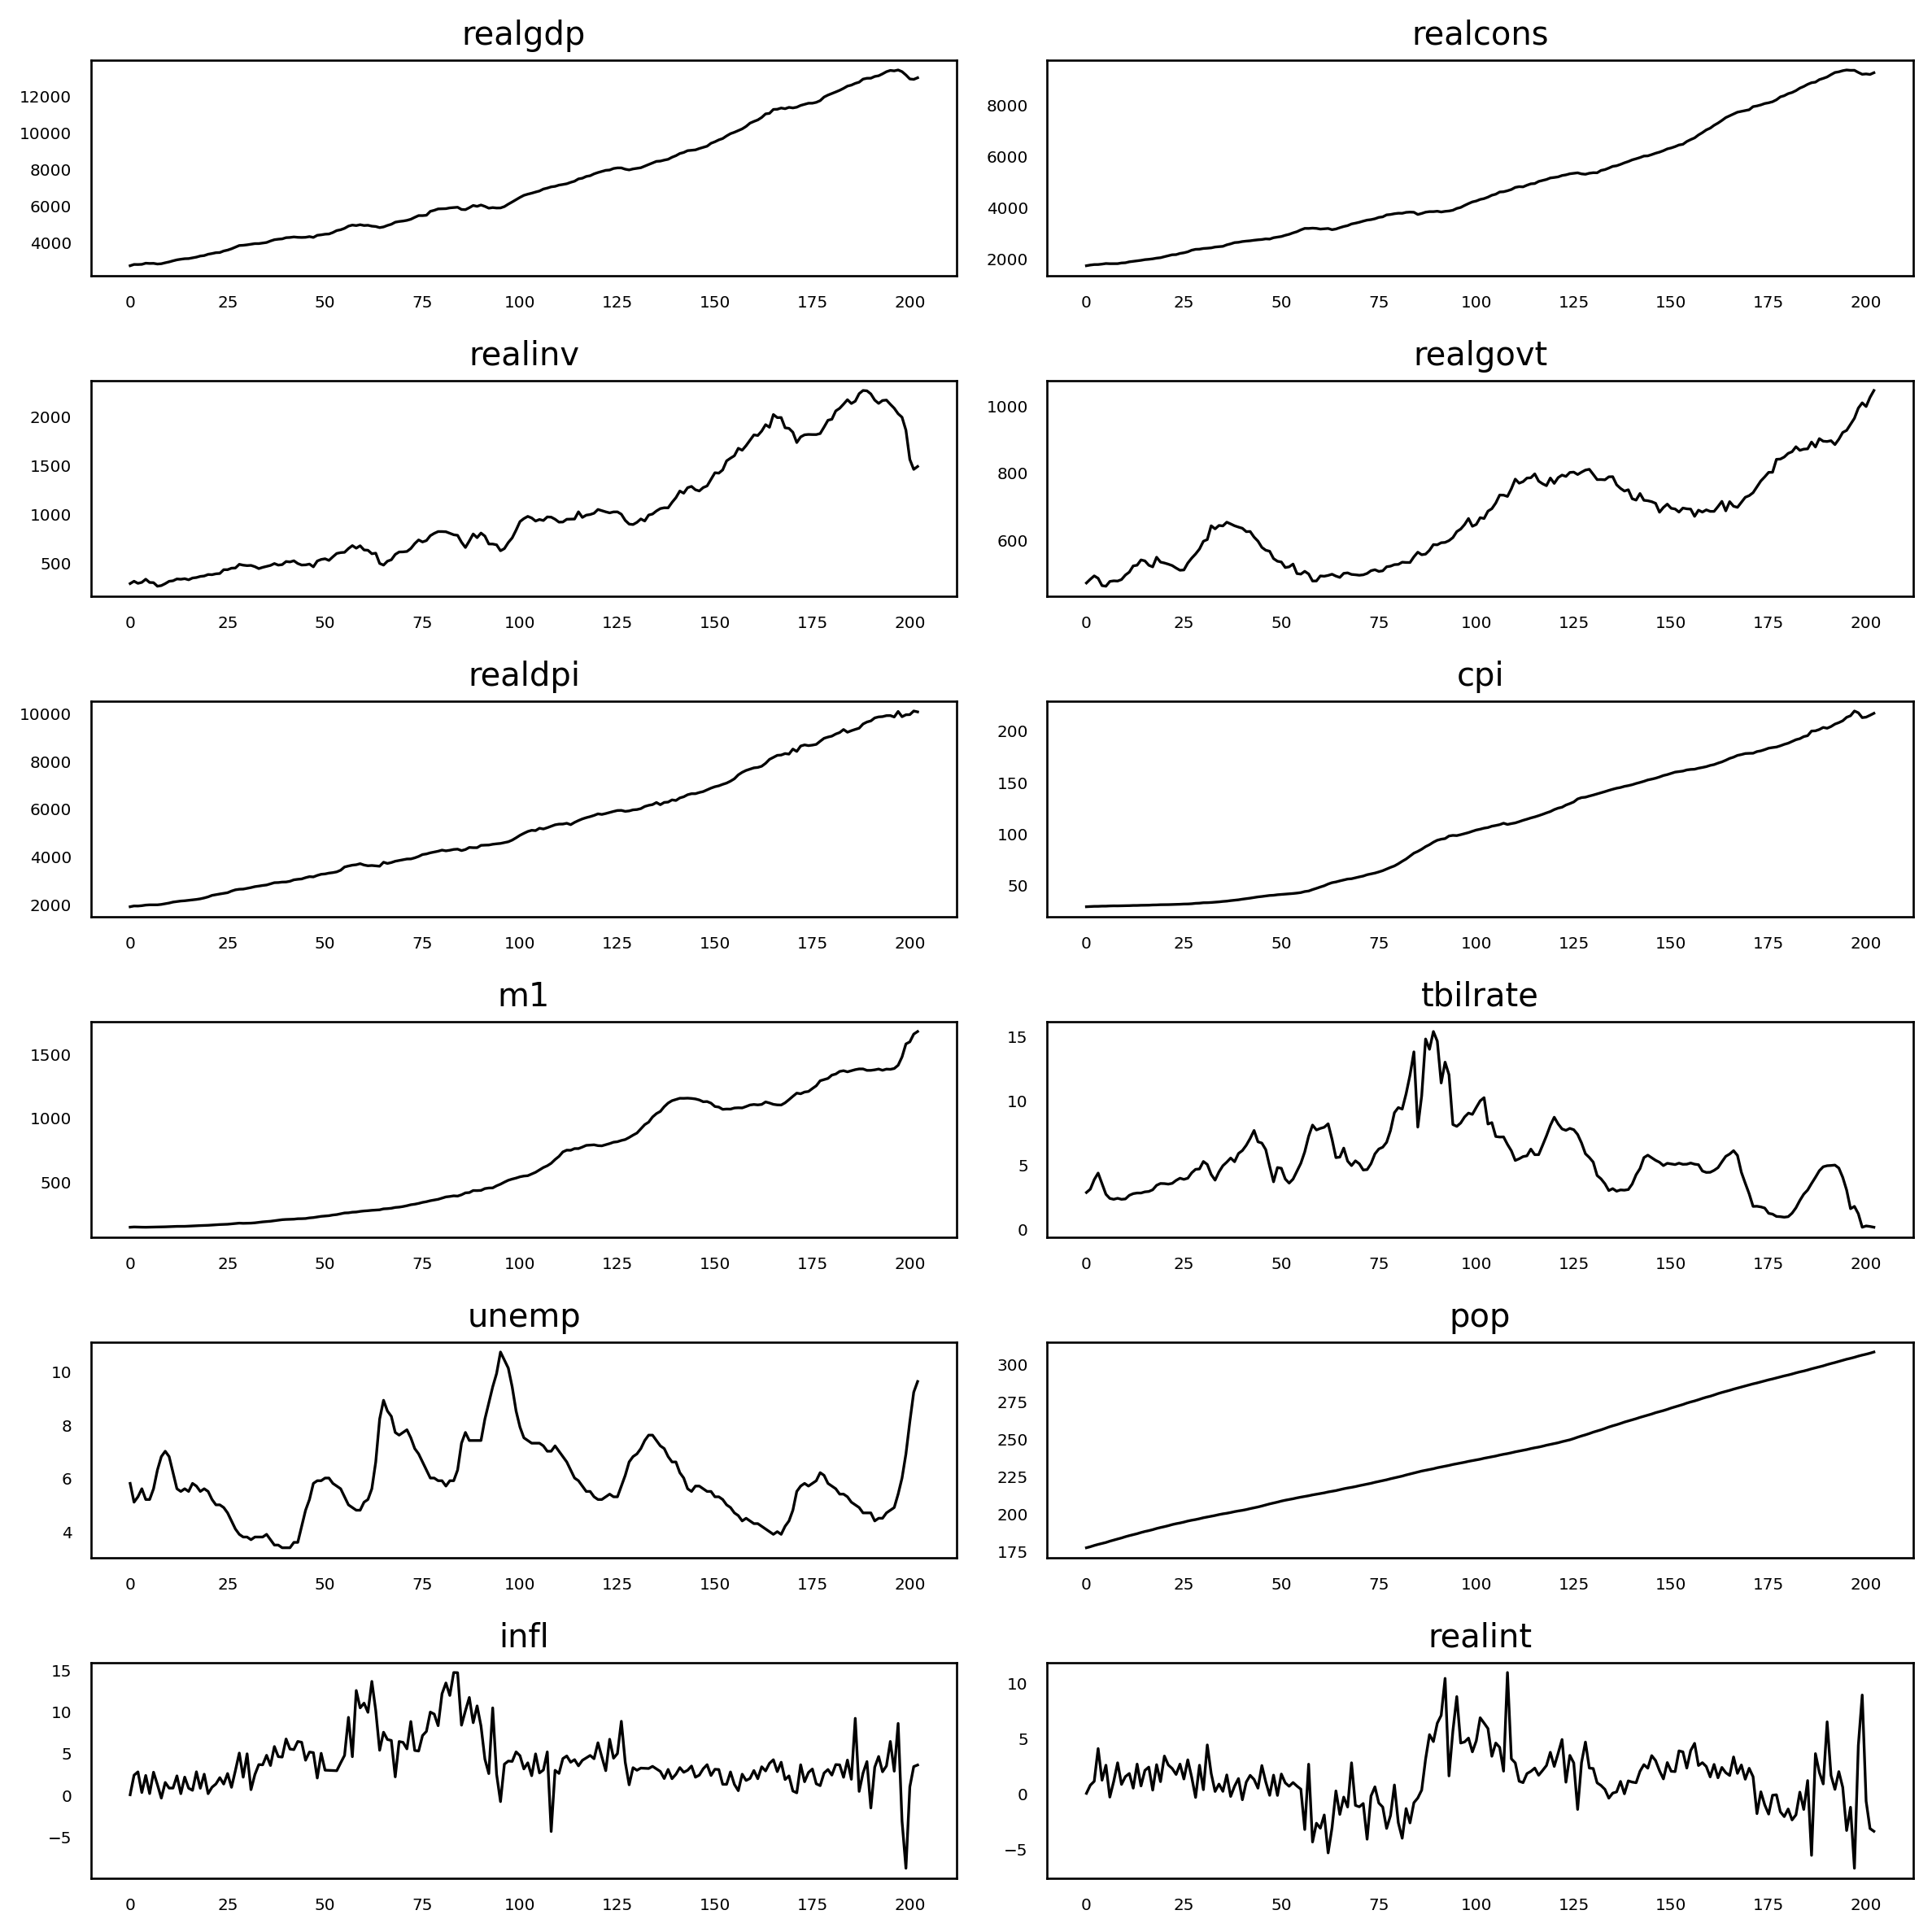

In [10]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=240, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    
    data = macro_data.data[macro_data.data.columns[i+2]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_data.data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout()

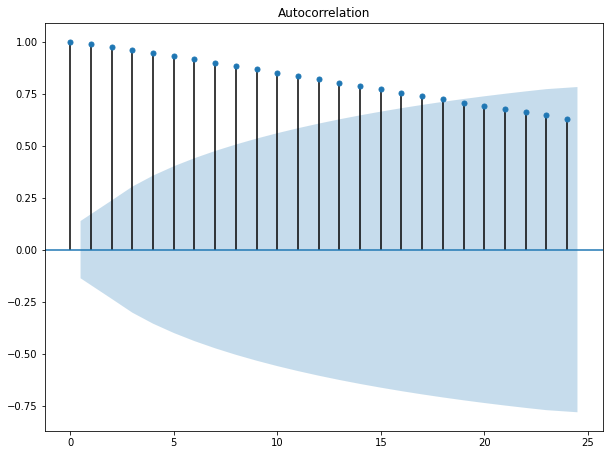

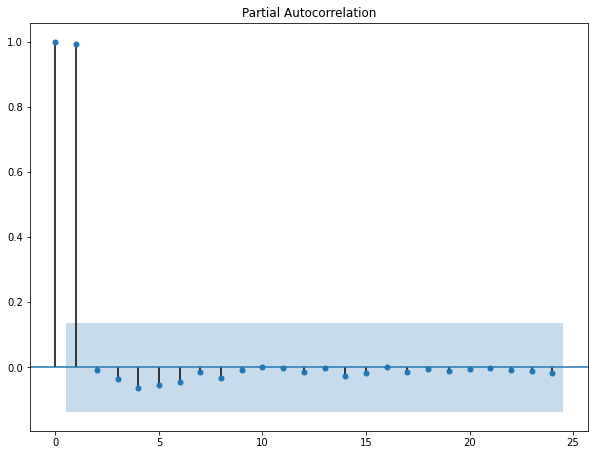

In [11]:
plot_acf(macro_data.data['realgdp']);
plot_pacf(macro_data.data['realgdp']);

In [12]:
ad_fuller_result = adfuller(macro_data.data['realgdp'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647128
p-value: 0.9982455372335032


In [13]:
macro_data.data['realgdp_tr'] = macro_data.data['realgdp'].diff()

macro_data.data.head(10)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,time,realgdp_tr
0,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00,1959-1,NaN
1,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,1959-2,68.452
2,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,1959-3,-3.313
3,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06,1959-4,9.716
4,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19,1960-1,62.495
5,1960,2,2834.390,1792.9,298.152,460.400,1966.1,29.55,140.2,2.68,5.2,180.671,0.14,2.55,1960-2,-13.309
6,1960,3,2839.022,1785.8,296.375,474.676,1967.8,29.75,140.9,2.36,5.6,181.528,2.70,-0.34,1960-3,4.632
7,1960,4,2802.616,1788.2,259.764,476.434,1966.6,29.84,141.1,2.29,6.3,182.287,1.21,1.08,1960-4,-36.406
8,1961,1,2819.264,1787.7,266.405,475.854,1984.5,29.81,142.1,2.37,6.8,182.992,-0.40,2.77,1961-1,16.648
9,1961,2,2872.005,1814.3,286.246,480.328,2014.4,29.92,142.9,2.29,7.0,183.691,1.47,0.81,1961-2,52.741


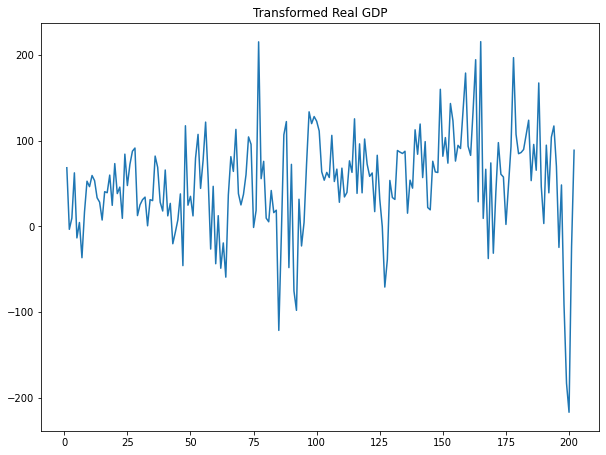

In [14]:
plt.plot(macro_data.data['realgdp_tr'])
plt.title('Transformed Real GDP')
plt.show()

In [15]:
ad_fuller_result = adfuller(macro_data.data['realgdp_tr'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08


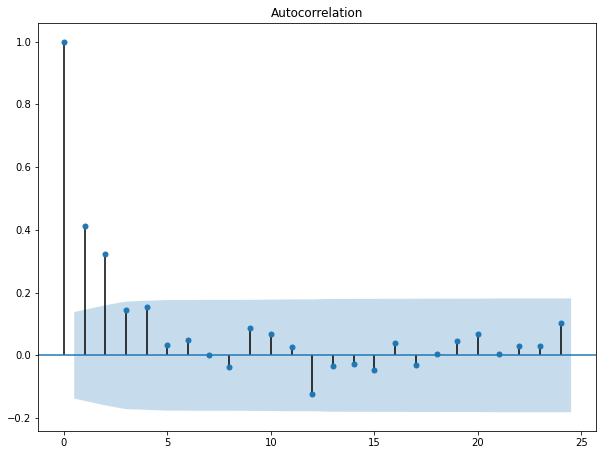

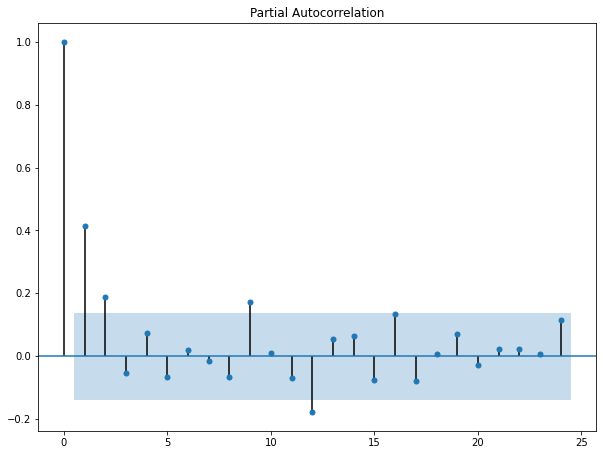

In [16]:
plot_acf(macro_data.data['realgdp_tr'][1:]);
plot_pacf(macro_data.data['realgdp_tr'][1:]);

In [17]:
def optimize_SARIMAX(endog, exog, parameters_list, d, D, s):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        endog - the observed variable
        exog - exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(endog, exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [18]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [19]:
endog = macro_data.data['realgdp'][:200]
exog = macro_data.data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']][:200]

result_df = optimize_SARIMAX(endog, exog, parameters_list, 1, 1, 4)
result_df

,"(p,q)x(P,Q)",AIC
0,"(1, 2, 2, 3)",1738.776225
1,"(2, 1, 2, 3)",1739.892031
2,"(1, 1, 2, 3)",1740.147349
3,"(1, 2, 3, 3)",1740.445330
4,"(1, 2, 0, 2)",1740.661774
...,...,...
251,"(0, 2, 0, 0)",1812.017945
252,"(2, 0, 0, 0)",1812.340619
253,"(1, 1, 0, 0)",1812.492358
254,"(3, 0, 0, 0)",1812.518357


In [20]:
best_model = SARIMAX(endog, exog, order=(1,1,2), seasonal_order=(2,0,3,4), simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                   realgdp   No. Observations:                  200
Model:             SARIMAX(1, 1, 2)x(2, 0, [1, 2, 3], 4)   Log Likelihood                -860.781
Date:                                   Sat, 31 Oct 2020   AIC                           1761.561
Time:                                           16:23:03   BIC                           1827.427
Sample:                                                0   HQIC                          1788.219
                                                   - 200                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9174      0.058     15.905      0.000    

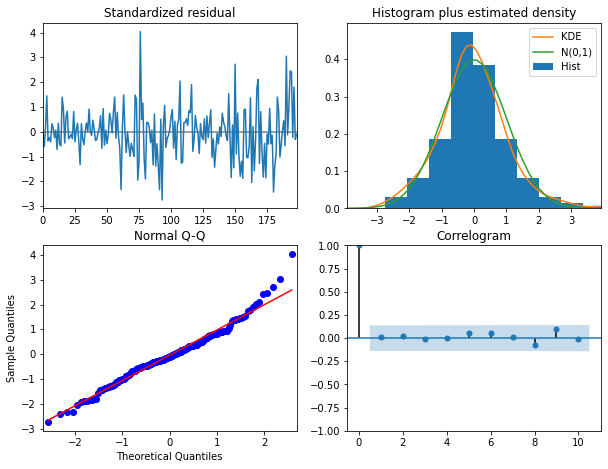

In [21]:
res.plot_diagnostics();

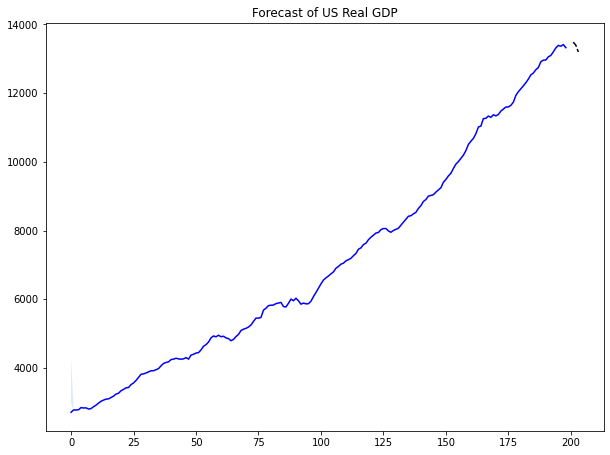

In [30]:
n_forecast = 3
predict = res.get_prediction(end=best_model.nobs + n_forecast, exog=exog.iloc[-4:])
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

fig, ax = plt.subplots()
ax.plot(macro_data.data['realgdp'][:199], color='blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15)

ax.set_title('Forecast of US Real GDP')
plt.show()

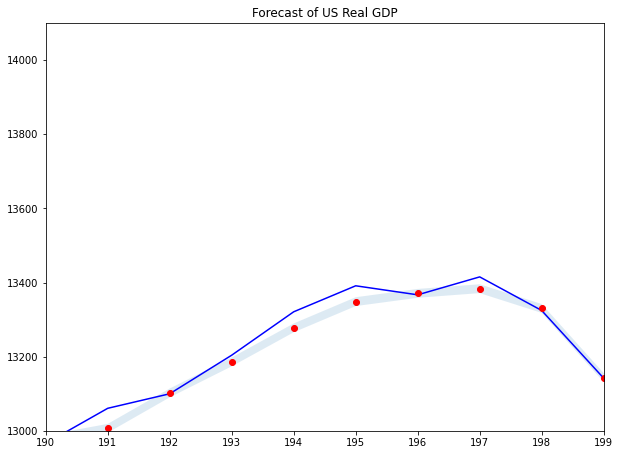

In [31]:
fig, ax = plt.subplots()
ax.plot(macro_data.data['realgdp'], color='blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.plot(predict.predicted_mean, 'ro')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15)
ax.set_xlim(190, 199)
ax.set_ylim(13000, 14100)

ax.set_title('Forecast of US Real GDP')
plt.show()

In [33]:
mse = mean_squared_error(macro_data.data['realgdp'], predict.predicted_mean[:203])
print(f'MSE: {mse}')

MSE: 8775.471006067057


In [38]:
mape = np.mean(np.abs(macro_data.data['realgdp'] - predict.predicted_mean[:203]) / np.abs(macro_data.data['realgdp']))

print(f'MAPE: {round(mape * 100, 2)}%')

MAPE: 0.44%
